overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj().generate()):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))
        assert len(param) == 22
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
#         result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        _df_collect.append(
            {
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                'kernel_size_l23': param['kernel_size_l23'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l23', 'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
#         'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l23', 'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [8]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)
corr_std = df['corr_test'].unstack('model_seed').std(axis=1)

In [9]:
corr_mean.unstack('rcnn_bl_cls')

rcnn_bl_cls                                                                                         1  \
act_fn   loss_type scale smoothness num_layer kernel_size_l23 out_channel 1st_bn_before_act             
relu     mse       0.01  0.000005   2         3               8           False              0.570708   
                                                                          True               0.572367   
                                                              16          False              0.599991   
                                                                          True               0.600333   
                                                              32          False              0.607998   
                                                                          True               0.607839   
                                              5               8           False              0.575470   
                                                                          True               0.552917   
                                                              16          False              0.594060   
                                                                          True               0.591612   
                                                              32          False              0.602530   
                                                                          True               0.600506   
                                              7               8           False              0.557276   
                                                                          True               0.548686   
                                                              16          False              0.591708   
                                                                          True               0.586642   
                                                              32          False              0.596656   
                                                                          True               0.596758   
                                              9               8           False              0.555080   
                                                                          True               0.556984   
                                                              16          False              0.584726   
                                                                          True               0.576955   
                                                              32          False              0.586657   
                                                                          True               0.585973   
                                    3         3               8           False              0.610299   
                                                                          True               0.607369   
                                                              16          False              0.644608   
                                                                          True               0.644864   
                                                              32          False              0.661373   
                                                                          True               0.662382   
                                              5               8           False              0.609965   
                                                                          True               0.613225   
                                                              16          False              0.640569   
                                                                          True               0.639670   
                                                              32          False              0.652886   
                                                                          True               0.651900   
          

In [10]:
corr_std.unstack('rcnn_bl_cls')

rcnn_bl_cls                                                                                         1  \
act_fn   loss_type scale smoothness num_layer kernel_size_l23 out_channel 1st_bn_before_act             
relu     mse       0.01  0.000005   2         3               8           False              0.003281   
                                                                          True               0.004708   
                                                              16          False              0.003480   
                                                                          True               0.000556   
                                                              32          False              0.001997   
                                                                          True               0.000761   
                                              5               8           False              0.001015   
                                                                          True               0.024201   
                                                              16          False              0.006057   
                                                                          True               0.002126   
                                                              32          False              0.002896   
                                                                          True               0.001341   
                                              7               8           False              0.021303   
                                                                          True               0.017108   
                                                              16          False              0.001672   
                                                                          True               0.003633   
                                                              32          False              0.001225   
                                                                          True               0.008459   
                                              9               8           False              0.002938   
                                                                          True               0.013108   
                                                              16          False              0.002536   
                                                                          True               0.000187   
                                                              32          False              0.004325   
                                                                          True               0.003119   
                                    3         3               8           False              0.003840   
                                                                          True               0.001509   
                                                              16          False              0.000840   
                                                                          True               0.001949   
                                                              32          False              0.001151   
                                                                          True               0.000902   
                                              5               8           False              0.006685   
                                                                          True               0.012227   
                                                              16          False              0.002026   
                                                                          True               0.001065   
                                                              32          False              0.002089   
                                                                          True               0.001327   
          

In [11]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [12]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(96,) (96,)


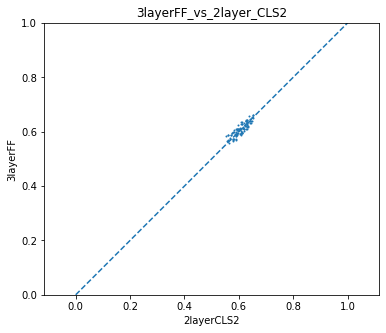

y-x mean 0.0028280770035223717 y-x>0 mean 0.5520833333333334
y top 0.6623817612567857 x top 0.6528465194052457


In [13]:
# check 3 layer cls = 1 vs 2 layer cls = 2
def check_3layerFF_vs_2layer_CLS2():
    corr_mean_3layerFF = corr_mean.xs(3, level='num_layer').xs(1, level='rcnn_bl_cls')
    corr_mean_2layerCLS2 = corr_mean.xs(2, level='num_layer').xs(2, level='rcnn_bl_cls')
    assert corr_mean_3layerFF.index.equals(corr_mean_2layerCLS2.index)
    print(corr_mean_3layerFF.shape, corr_mean_2layerCLS2.shape)
    scatter(corr_mean_2layerCLS2.values, corr_mean_3layerFF.values, '2layerCLS2', '3layerFF', '3layerFF_vs_2layer_CLS2')
    
# the first jump is mostly due to number of parameter increase.
check_3layerFF_vs_2layer_CLS2()

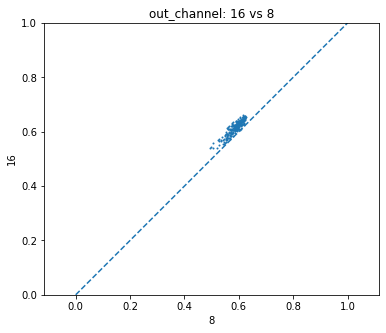

y-x mean 0.029437942444379202 y-x>0 mean 1.0
y top 0.6619089130912217 x top 0.626720381852992


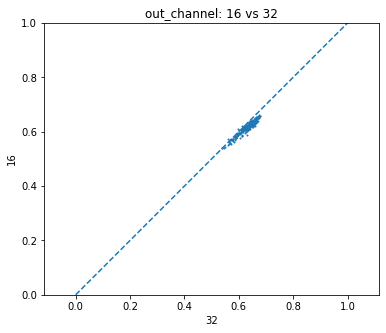

y-x mean -0.01357416878472294 y-x>0 mean 0.0625
y top 0.6619089130912217 x top 0.6793490195094402


In [14]:
check_compare_one_case(corr_mean, 'out_channel', [8, 16])
check_compare_one_case(corr_mean, 'out_channel', [32, 16])

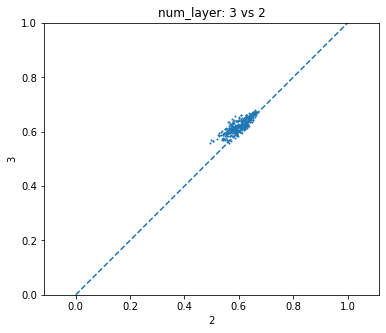

y-x mean 0.021312845920165868 y-x>0 mean 0.8697916666666666
y top 0.6793490195094402 x top 0.6713977054885603


In [15]:
# 3 layer out performs consistently, by a small margin.
check_compare_one_case(corr_mean, 'num_layer')

In [16]:
corr_mean_refine = corr_mean.xs(3, level='num_layer')

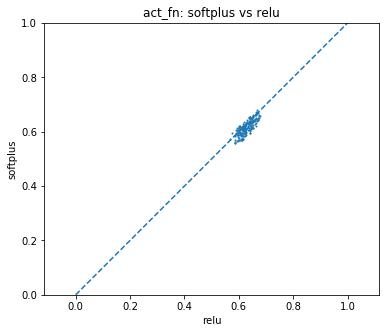

y-x mean -0.012260951313576046 y-x>0 mean 0.265625
y top 0.6793490195094402 x top 0.6763025323969925


In [17]:
# relu better.
check_compare_one_case(corr_mean_refine, 'act_fn')

In [18]:
corr_mean_refine = corr_mean_refine.xs('relu', level='act_fn')

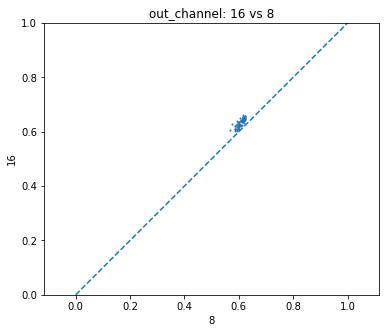

y-x mean 0.027669366246954208 y-x>0 mean 1.0
y top 0.6619089130912217 x top 0.624065851561864


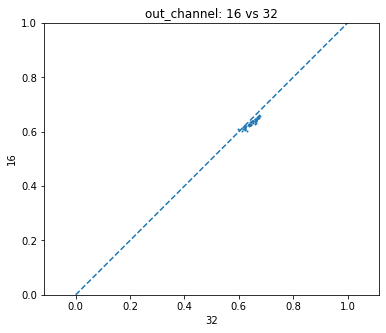

y-x mean -0.013939378347568731 y-x>0 mean 0.046875
y top 0.6619089130912217 x top 0.6763025323969925


In [19]:
# 16 is good.
check_compare_one_case(corr_mean_refine, 'out_channel', [8, 16])
check_compare_one_case(corr_mean_refine, 'out_channel', [32, 16])

In [20]:
corr_mean_refine = corr_mean_refine.xs(16, level='out_channel')

In [21]:
corr_mean_refine.unstack('rcnn_bl_cls')
# large kernel like 13 is bad.

rcnn_bl_cls                                                          1  \
loss_type scale smoothness kernel_size_l23 1st_bn_before_act             
mse       0.01  0.000005   3               False              0.644608   
                                           True               0.644864   
                           5               False              0.640569   
                                           True               0.639670   
                           7               False              0.623338   
                                           True               0.626122   
                           9               False              0.604385   
                                           True               0.615803   
poisson   0.01  0.000005   3               False              0.628480   
                                           True               0.629603   
                           5               False              0.634724   
                                           True               0.627629   
                           7               False              0.611410   
                                           True               0.624996   
                           9               False              0.605137   
                                           True               0.609039   

rcnn_bl_cls                                                          2  \
loss_type scale smoothness kernel_size_l23 1st_bn_before_act             
mse       0.01  0.000005   3               False              0.653714   
                                           True               0.661909   
                           5               False              0.646350   
                                           True               0.653939   
                           7               False              0.638399   
                                           True               0.635189   
                           9               False              0.621721   
                                           True               0.616346   
poisson   0.01  0.000005   3               False              0.638642   
                                           True               0.652166   
                           5               False              0.630877   
                                           True               0.646353   
                           7               False              0.626046   
                                           True               0.624139   
                           9               False              0.613696   
                                           True               0.601895   

rcnn_bl_cls                                                          3  \
loss_type scale smoothness kernel_size_l23 1st_bn_before_act             
mse       0.01  0.000005   3               False              0.652913   
                                           True               0.656403   
                           5               False              0.648017   
                                           True               0.650799   
                           7               False              0.636229   
                                           True               0.639351   
                           9               False              0.619955   
                                           True               0.611624   
poisson   0.01  0.000005   3               False              0.649586   
                                           True               0.642153   
                           5               False              0.641612   
                                           True               0.636872   
                           7               False              0.628939   
                                           True               0.637941   
                           9               False              0.607946   
                                           True               0.611562   

r

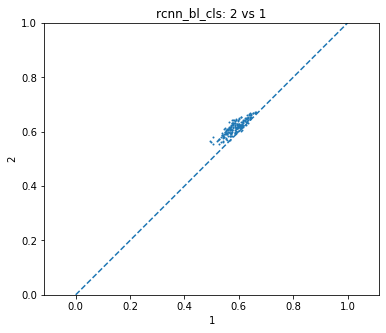

y-x mean 0.03033715209098801 y-x>0 mean 0.9791666666666666
y top 0.6729718809386906 x top 0.6623817612567857


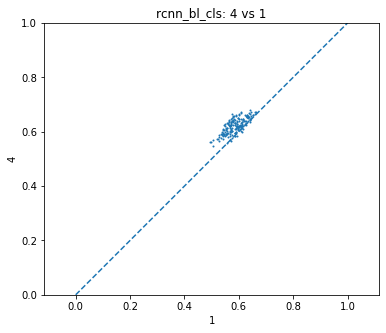

y-x mean 0.03581160626434828 y-x>0 mean 0.953125
y top 0.6793490195094402 x top 0.6623817612567857


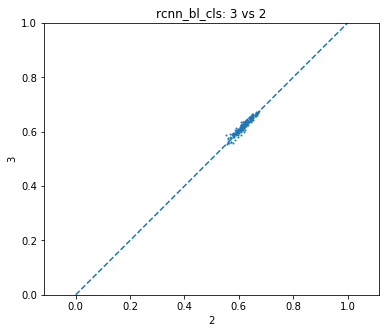

y-x mean 0.004814975653525607 y-x>0 mean 0.6979166666666666
y top 0.6763025323969925 x top 0.6729718809386906


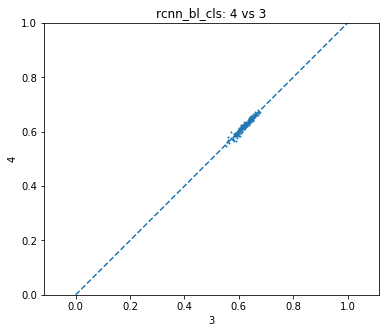

y-x mean 0.0006594785198346652 y-x>0 mean 0.5416666666666666
y top 0.6793490195094402 x top 0.6763025323969925


In [22]:
# there is difference between having lateral vs not, but not much after that.
# maybe data is not sufficient
check_compare_one_case(corr_mean, 'rcnn_bl_cls', [1,2])
check_compare_one_case(corr_mean, 'rcnn_bl_cls', [1,4])
check_compare_one_case(corr_mean, 'rcnn_bl_cls', [2,3])
check_compare_one_case(corr_mean, 'rcnn_bl_cls', [3,4])

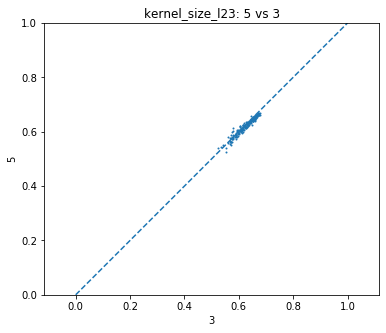

y-x mean -0.003397340410924128 y-x>0 mean 0.28125
y top 0.6705835734128016 x top 0.6793490195094402


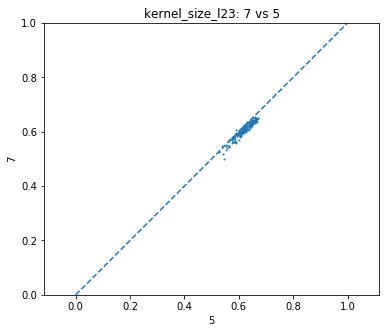

y-x mean -0.012237988246227557 y-x>0 mean 0.10416666666666667
y top 0.6534402255162035 x top 0.6705835734128016


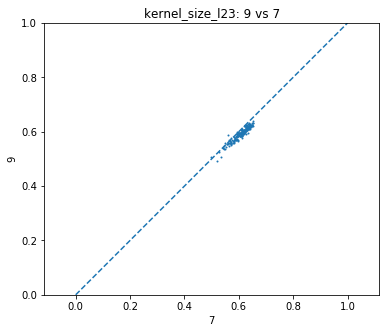

y-x mean -0.01461897975340772 y-x>0 mean 0.046875
y top 0.6378764417306145 x top 0.6534402255162035


In [23]:
# 3 is the best.
check_compare_one_case(corr_mean, 'kernel_size_l23', [3, 5])
check_compare_one_case(corr_mean, 'kernel_size_l23', [5, 7])
check_compare_one_case(corr_mean, 'kernel_size_l23', [7, 9])

In [24]:
corr_mean_kernel3 = corr_mean.xs(3, level='kernel_size_l23')

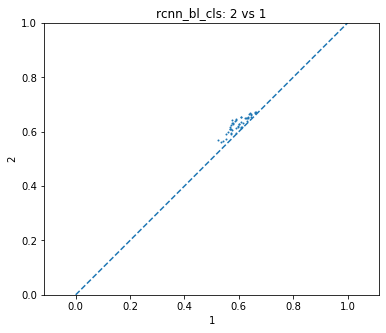

y-x mean 0.029584268475115222 y-x>0 mean 1.0
y top 0.6729718809386906 x top 0.6623817612567857


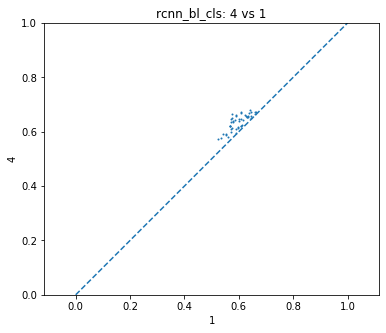

y-x mean 0.037486346853202145 y-x>0 mean 1.0
y top 0.6793490195094402 x top 0.6623817612567857


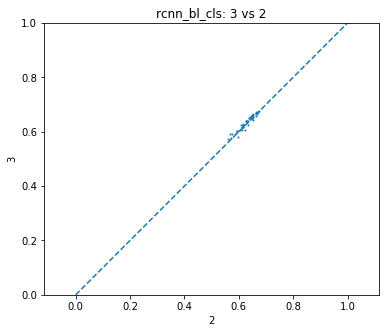

y-x mean 0.005058711595277207 y-x>0 mean 0.75
y top 0.6763025323969925 x top 0.6729718809386906


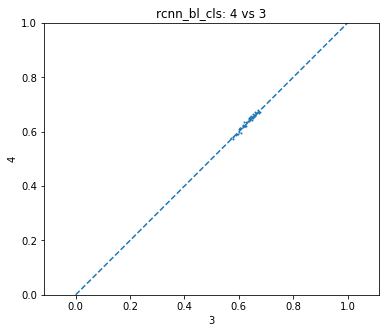

y-x mean 0.002843366782809708 y-x>0 mean 0.6666666666666666
y top 0.6793490195094402 x top 0.6763025323969925


In [25]:
check_compare_one_case(corr_mean_kernel3, 'rcnn_bl_cls', [1,2])
check_compare_one_case(corr_mean_kernel3, 'rcnn_bl_cls', [1,4])
check_compare_one_case(corr_mean_kernel3, 'rcnn_bl_cls', [2,3])
check_compare_one_case(corr_mean_kernel3, 'rcnn_bl_cls', [3,4])

(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.029584268475115222 sem 0.0023691908064684014
3 - 2 mean 0.005058711595277207 sem 0.0011520950345487745
4 - 3 mean 0.002843366782809708 sem 0.0008682186522390155
4 - 2 mean 0.007902078378086916 sem 0.0013188904547508022


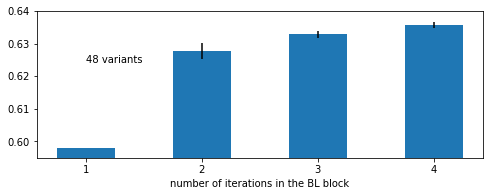

In [26]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0, 0.625, f'{n} variants', verticalalignment='center', horizontalalignment='left')
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean_kernel3, [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))

(192, 4)
[1, 2, 3, 4]
n 192
2 - 1 mean 0.03033715209098801 sem 0.00125832469301383
3 - 2 mean 0.004814975653525607 sem 0.0006350140183035399
4 - 3 mean 0.0006594785198346652 sem 0.0005253389747149356
4 - 2 mean 0.005474454173360272 sem 0.0007497707100063192


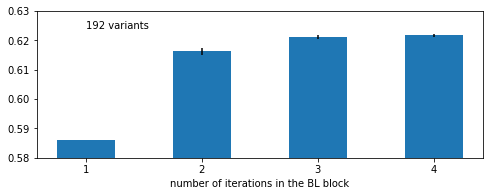

In [27]:
plot_step_increase(corr_mean, [(1,2),(2,3),(3,4),(2,4)], (0.58, 0.63))